In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
bus = pd.read_csv('~/Downloads/arrival_times.csv')
bus = bus.dropna(axis=0, how='any')

# combine date and time into a single timestamp
bus['scheduled'] = pd.to_datetime(bus['OPD_DATE'] + ' ' + bus['SCH_STOP_TM'])
bus['actual'] = pd.to_datetime(bus['OPD_DATE'] + ' ' + bus['ACT_STOP_TM'])

# if scheduled & actual span midnight, then the actual day needs to be adjusted
minute = np.timedelta64(1, 'm')
hour = 60 * minute
diff_hrs = (bus['actual'] - bus['scheduled']) / hour
bus.loc[diff_hrs > 20, 'actual'] -= 24 * hour
bus.loc[diff_hrs < -20, 'actual'] += 24 * hour
bus['minutes_late'] = (bus['actual'] - bus['scheduled']) / minute

bus['route'] = bus['RTE'].replace({673: 'C', 674: 'D', 675: 'E'})
bus['direction'] = bus['DIR'].replace({'N': 'northbound', 'S': 'southbound'})

bus = bus[['route', 'direction', 'scheduled', 'actual', 'minutes_late']].copy()

# Exploring Bus Times

We learned a lot about the data as we cleaned and simplified it, but before we begin to model wait time, we want to dig deeper to better understand the phenomena of bus lateness. We have narrowed our focus to the bus activity at one stop (Third Avenue and Pike Street) over a two-month period. And, we saw that the distribution of the lateness of a bus is skewed to the right with some buses being very late indeed. In this exploratory phase, we might ask:

+ Does the distribution of lateness look the same for all three bus lines?
+ Does it matter whether the bus is traveling north- or south-bound?
+ How does the time of day relate to how late the bus is?
+ Are the buses scheduled to arrive at regular intervals throughout the day? 

Answering these questions helps us better determine how to model. 

Recall from {numref}`Chapter %s <ch:modeling>` that we found the median time a bus was late was 3/4 of a minute. But, this doesn't match the median we calculated for all bus routes and directions (1/2 a minute). Could that be due to the focus on northbound line C buses in that chapter? We can look at histograms of lateness for each of the six combinations of bus line and direction, and these histograms also address the first two questions of our exploratory phase. 

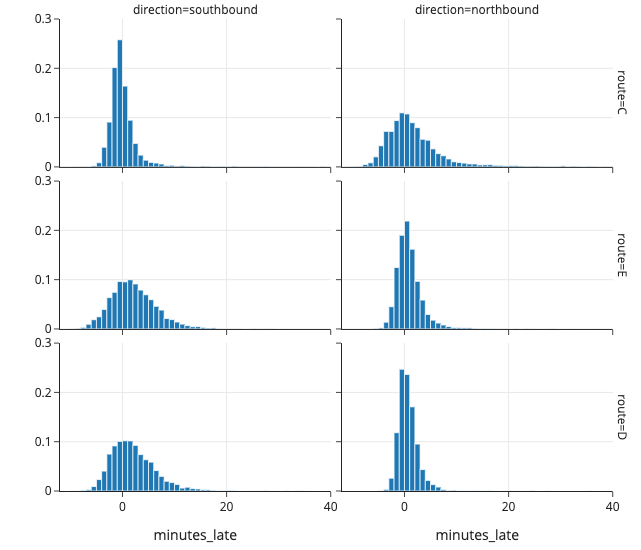

In [6]:
fig = px.histogram(bus, x='minutes_late',
                   histnorm='probability density',
                   nbins = 200,
                facet_row='route', facet_col='direction',
                width=550, height=550)

fig.update_xaxes(range=[-12, 40])
fig.update_yaxes(range=[0, 0.3], 
                 title="")

fig.show()

The scale on the $ y $-axis is proportion (or density). This scale makes it easier to compare the histograms because we are not misled by different counts in the groups. The range on the $ x $-axis is the same across the six plots making it easier to detect changes in location and spread of the distributions. (These notions are described in {numref}`Chapter %s <ch:viz>`.)

The northbound and southbound distributions are different for each line. When we dig deeper into the context, we learn that line C originates in the north and the other two lines originate in the south. This implies there is greater variability in arrival times in the second half of the bus routes.

Next, to explore lateness by the time of day, we need to derive a new quantity--the hour of the day that the bus is scheduled to arrive. Given the variation in route and direction that we just saw in bus lateness, we  again create separate plots for each route and direction. 

In [8]:
bus['hour_of_day'] = bus['scheduled'].dt.hour

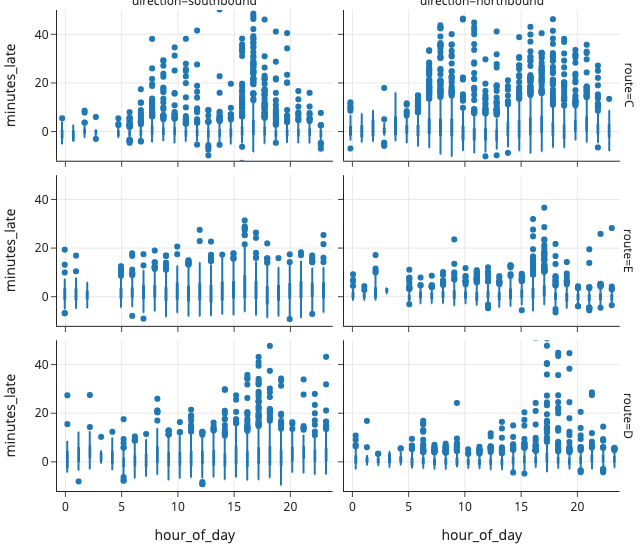

In [9]:
fig = px.box(bus, y='minutes_late', x='hour_of_day',                 
             facet_row='route', facet_col='direction',
             width=550, height=550)

fig.update_yaxes(range=[-12, 50])

fig.show()

Indeed, there does appear to be a rush-hour effect, and it seems worse for the evening rush hour compared to the morning. The northbound C line looks to be the most impacted. 

In [11]:
bus_c_n = bus[(bus['route'] == 'C') &
                 (bus['direction'] == 'northbound')].copy()

Lastly, to examine the scheduled frequency of the buses, we need to compute the intervals between scheduled bus times. We create a new column in our table that contains the time between the buses scheduled arrival times. We examine in a histogram the distribution of inter-arrival times of buses on line C. 

In [12]:
bus_c_n = bus_c_n.sort_values('scheduled')

minute = np.timedelta64(1, 'm')
bus_c_n['sched_inter'] = bus_c_n['scheduled'].diff() / minute

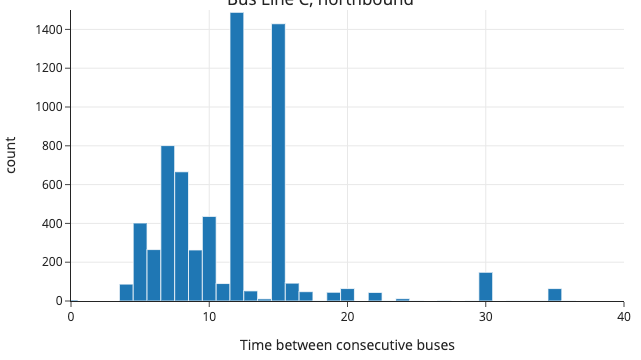

In [13]:
fig = px.histogram(bus_c_n, x='sched_inter', 
                   title="Bus Line C, northbound",
                   width=450, height=300)


fig.update_xaxes(range=[0, 40], title="Time between consecutive buses")
fig.update_yaxes(range=[0, 1500])

fig.show()

We see that the buses are not scheduled to arrive at the same interval throughout the day. In this two month period, about 1500 of the buses were scheduled to arrive 12 minutes apart and about 1400 are supposed to arrive 15 minutes after the previous bus. 

We have learned a lot in our exploration of the data and are in a better position to fit a model well. Most notably, if we want to get a clear picture of the experience of waiting for a bus, we need to take into account the scheduled interval between buses, as well as the bus line and direction. 